In [1]:
import numpy.random
from kendall import Simulator, Entity, Stream, UniformSpawner, Queue, RandomSplitter, Splitter, Worker, Merger, Dropper
from kendall.main import SISOStream

def average(list):
    return sum(list) / float(len(list))

class Guest(Entity):
    def __init__(self, *args, **kwargs):
        super(Guest, self).__init__(*args, **kwargs)
        self.exited = False
        self.seen_attractions = 0
        # Normal distribution with mean 19.9 and variance 4.04
        self.speed = numpy.random.normal(19.9, 2.009975124224178)

    def on_enter(self, stream, time):
        super(Guest, self).on_enter(stream, time)
        if stream.name == "Exit":
            self.exited = True

    def on_exit(self, stream, time):
        super(Guest, self).on_exit(stream, time)
        if stream.name in ["Attraction A", "Attraction B", "Attraction C", "Attraction D"]:
            self.seen_attractions += 1


class GuestSpawner(UniformSpawner):
    def create_entity(self, time):
        return Guest()

class DockDeposit(SISOStream):
    def __init__(self, *args, **kwargs):
        super(DockDeposit, self).__init__(*args, **kwargs)
        self.slots = kwargs.get("slots")
        self.free_slots = self.slots
        self.linked_claim = None

    def start(self):
        if self.linked_claim is None:
            raise Exception("DockDeposits need a linked DockClaim!!")
        self.free_slots = self.slots - self.linked_claim.bikes

    def enter(self, entity, time):
        # print "Guest {} entered {} with {} at {}".format(entity.id, self.name, self.free_slots, time)
        if self.free_slots > 0:
            self.free_slots -= 1
            self.linked_claim.put_bike(time)
            entity.on_enter(self, time)
            entity.on_exit(self, time)
            self.destination.enter(entity, time)
        else:
            raise Exception("You're not supposed to deposit a bike with no empty slots")

    def ready(self):
        return self.free_slots > 0 and self.destination.ready()

    def link_claim(self, claim):
        self.linked_claim = claim
        claim.linked_deposit = self

    def take_bike(self, time):
        self.free_slots += 1
        if self.free_slots == 1 and self.ready():
            self.source.notify_ready(self, time)

    # The next two methods are not necessary. I just put them for completeness
    def notify_ready(self, other, time):
        if self.ready():
            self.source.notify_ready(self, time)

    def notify_unready(self, other, time):
        if self.free_slots > 0:
            self.source.notify_unready(self, time)


class DockClaim(SISOStream):
    def __init__(self, *args, **kwargs):
        super(DockClaim, self).__init__(*args, **kwargs)
        self.bikes = kwargs.get("bikes")
        self.free_bikes = self.bikes
        self.linked_deposit = None

    def start(self):
        if self.linked_deposit is None:
            raise "DockClaims need a linked DockDeposit!!"
        self.free_bikes = self.bikes

    def enter(self, entity, time):
        # print "Guest {} entered {} with {} at {}".format(entity.id, self.name, self.free_bikes, time)
        if self.free_bikes > 0:
            self.free_bikes -= 1
            self.linked_deposit.take_bike(time)
            entity.on_enter(self, time)
            entity.on_exit(self, time)
            self.destination.enter(entity, time)
        else:
            raise "You're not supposed to claim a bike with no free bikes"

    def ready(self):
        return self.free_bikes > 0 and self.destination.ready()

    def put_bike(self, time):
        self.free_bikes += 1
        if self.free_bikes == 1 and self.ready():
            self.source.notify_ready(self, time)

    # The next two methods are not necessary. I just put them for completeness
    def notify_ready(self, other, time):
        if self.ready():
            self.source.notify_ready(self, time)

    def notify_unready(self, other, time):
        if self.free_slots > 0:
            self.source.notify_unready(self, time)


class ParkPath(Worker):
    def __init__(self, *args, **kwargs):
        super(ParkPath, self).__init__(*args, **kwargs)
        self.distance = float(kwargs["distance"])

    def time_to_finish(self, entity, time):
        return self.distance / entity.speed


class Attraction(Worker):
    def __init__(self, *args, **kwargs):
        super(Attraction, self).__init__(*args, **kwargs)
        self.mean = float(kwargs["mean"])
        self.sd = float(kwargs["variance"])**0.5

    def time_to_finish(self, entity, time):
        return numpy.random.normal(self.mean, self.sd)


class DroppingSplitter(Splitter):
    def start(self):
        super(DroppingSplitter, self).start()
        # Just need to remember who the dropper is for a minor speedup
        self.regulars = []
        self.droppers = []
        for d in self.destinations:
            if isinstance(d, Dropper):
                self.droppers.append(d)
            else:
                self.regulars.append(d)

    def select_destination(self, entity, time):
        if entity.seen_attractions >= 4:
            for d in self.ready_destinations:
                if d in self.droppers:
                    return d
        else:
            for d in self.destinations:
                if d in self.regulars:
                    return d

    
class ParkSimulator(Simulator):
    def __init__(self, *args, **kwargs):
        super(ParkSimulator, self).__init__(*args, **kwargs)
        self.dock_a_slots = kwargs.get("dock_a_slots", 80)
        self.dock_b_slots = kwargs.get("dock_b_slots", 80)
        self.dock_c_slots = kwargs.get("dock_c_slots", 80)
        self.dock_d_slots = kwargs.get("dock_d_slots", 80)
        self.dock_a_bikes = kwargs.get("dock_a_bikes", 80)
        self.dock_b_bikes = kwargs.get("dock_b_bikes", 80)
        self.dock_c_bikes = kwargs.get("dock_c_bikes", 80)
        self.dock_d_bikes = kwargs.get("dock_d_bikes", 80)

    def create_streams(self):
#         self.spawner = GuestSpawner(name="Entrance", spawn_time=1.25)
#         self.attraction_picker = RandomSplitter(name="Attraction Picker")
        self.spawner_a = GuestSpawner(name="Spawner A", low=16, high=1520)
        self.spawner_b = GuestSpawner(name="Spawner B", low=17, high=1530)
        self.spawner_c = GuestSpawner(name="Spawner C", low=27, high=1540)
        self.spawner_d = GuestSpawner(name="Spawner D", low=1, high=1530)
        self.dropper = Dropper(name="Exit")

        self.deposit_queue_a = Queue(name="Deposit Queue A", capacity=10**100)
        self.deposit_a = DockDeposit(name="Deposit A", slots=self.dock_a_slots)
        self.attraction_merger_a = Merger(name="Attraction Merger A")
        self.attraction_a = Attraction(name="Attraction A", capacity=10**100, mean=29.5, variance=5.11)
        self.attraction_decision_a = DroppingSplitter(name="Attraction Decision A")
        self.claim_queue_a = Queue(name="Claim Queue A", capacity=10**100)
        self.claim_a = DockClaim(name="Claim A", bikes=self.dock_a_bikes)
        self.path_a_to_b = ParkPath(name="Path A to B", distance=3.0, capacity=10**100)
        self.deposit_a.link_claim(self.claim_a)

        self.deposit_queue_b = Queue(name="Deposit Queue B")
        self.deposit_b = DockDeposit(name="Deposit B", slots=self.dock_b_slots)
        self.attraction_merger_b = Merger(name="Attraction Merger B")
        self.attraction_b = Attraction(name="Attraction B", capacity=10**100, mean=30, variance=5.29)
        self.attraction_decision_b = DroppingSplitter(name="Attraction Decision B")
        self.claim_queue_b = Queue(name="Claim Queue B", capacity=10**100)
        self.claim_b = DockClaim(name="Claim B", bikes=self.dock_b_bikes)
        self.path_b_to_c = ParkPath(name="Path B to C", distance=3.5, capacity=10**100)
        self.deposit_b.link_claim(self.claim_b)

        self.deposit_queue_c = Queue(name="Deposit Queue C")
        self.deposit_c = DockDeposit(name="Deposit C", slots=self.dock_c_slots)
        self.attraction_merger_c = Merger(name="Attraction Merger C")
        self.attraction_c = Attraction(name="Attraction C", capacity=10**100, mean=30, variance=4.96)
        self.attraction_decision_c = DroppingSplitter(name="Attraction Decision C")
        self.claim_queue_c = Queue(name="Claim Queue C", capacity=10**100)
        self.claim_c = DockClaim(name="Claim C", bikes=self.dock_c_bikes)
        self.path_c_to_d = ParkPath(name="Path A to B", distance=4.0, capacity=10**100)
        self.deposit_c.link_claim(self.claim_c)

        self.deposit_queue_d = Queue(name="Deposit Queue D")
        self.deposit_d = DockDeposit(name="Deposit D", slots=self.dock_d_slots)
        self.attraction_merger_d = Merger(name="Attraction Merger D")
        self.attraction_d = Attraction(name="Attraction D", capacity=10**100, mean=30, variance=5.01)
        self.attraction_decision_d = DroppingSplitter(name="Attraction Decision D")
        self.claim_queue_d = Queue(name="Claim Queue D", capacity=10**100)
        self.claim_d = DockClaim(name="Claim D", bikes=self.dock_d_bikes)
        self.path_d_to_a = ParkPath(name="Path D to A", distance=2.0, capacity=10**100)
        self.deposit_d.link_claim(self.claim_d)

        self.deposit_queue_a.pipe(self.deposit_a)
        self.deposit_a.pipe(self.attraction_merger_a)
        self.attraction_merger_a.pipe(self.attraction_a)
        self.attraction_a.pipe(self.attraction_decision_a)
        self.attraction_decision_a.pipe(self.claim_queue_a)
        self.claim_queue_a.pipe(self.claim_a)
        self.claim_a.pipe(self.path_a_to_b)
        self.path_a_to_b.pipe(self.deposit_queue_b)

        self.deposit_queue_b.pipe(self.deposit_b)
        self.deposit_b.pipe(self.attraction_merger_b)
        self.attraction_merger_b.pipe(self.attraction_b)
        self.attraction_b.pipe(self.attraction_decision_b)
        self.attraction_decision_b.pipe(self.claim_queue_b)
        self.claim_queue_b.pipe(self.claim_b)
        self.claim_b.pipe(self.path_b_to_c)
        self.path_b_to_c.pipe(self.deposit_queue_c)

        self.deposit_queue_c.pipe(self.deposit_c)
        self.deposit_c.pipe(self.attraction_merger_c)
        self.attraction_merger_c.pipe(self.attraction_c)
        self.attraction_c.pipe(self.attraction_decision_c)
        self.attraction_decision_c.pipe(self.claim_queue_c)
        self.claim_queue_c.pipe(self.claim_c)
        self.claim_c.pipe(self.path_c_to_d)
        self.path_c_to_d.pipe(self.deposit_queue_d)

        self.deposit_queue_d.pipe(self.deposit_d)
        self.deposit_d.pipe(self.attraction_merger_d)
        self.attraction_merger_d.pipe(self.attraction_d)
        self.attraction_d.pipe(self.attraction_decision_d)
        self.attraction_decision_d.pipe(self.claim_queue_d)
        self.claim_queue_d.pipe(self.claim_d)
        self.claim_d.pipe(self.path_d_to_a)
        self.path_d_to_a.pipe(self.deposit_queue_a)

        # self.spawner.pipe(self.attraction_picker)

        self.spawner_a.pipe(self.attraction_merger_a)
        self.spawner_b.pipe(self.attraction_merger_b)
        self.spawner_c.pipe(self.attraction_merger_c)
        self.spawner_d.pipe(self.attraction_merger_d)

        self.attraction_decision_a.pipe(self.dropper)
        self.attraction_decision_b.pipe(self.dropper)
        self.attraction_decision_c.pipe(self.dropper)
        self.attraction_decision_d.pipe(self.dropper)

    def reset(self):
        super(ParkSimulator, self).reset()
        Entity.id = 0

    def analyze(self):
        # debug_entities(self)
        pass


def create_simulator(*args, **kwargs):
    sim = ParkSimulator(*args, **kwargs)
    Stream.simulator = sim
    sim.create_streams()
    return sim


In [2]:
claims = set(["Claim A", "Claim B", "Claim C", "Claim D"])
deposits = set(["Deposit A", "Deposit B", "Deposit C", "Deposit D"])


def debug_entities(simulator):
    print "Entity list: ", len(simulator.entity_list)
    for e in simulator.entity_list[:10]:
        print e.id
        for evt in e.event_list:
            if evt[2] in claims.union(deposits):
                print evt
        # print e.event_table

def event_timeline(simulator):
    all_events = []
    for entity in simulator.entity_list[:10]:
        all_events.extend(entity.event_list)
    all_events.sort()
    return all_events

def time_between_events(entity, event1, event2):
    if entity.event_table.get(event1) and entity.event_table.get(event2):
        return entity.event_table.get(event2) - entity.event_table.get(event1)
    else:
        return None


def fn_time_between_events(event1, event2):
    def fn(entity):
        return time_between_events(entity, event1, event2)
    return fn


def total_waiting_time(guest):
    event_pairs = [
        (('Deposit Queue A', 'enter'), ('Deposit Queue A', 'exit')),
        (('Deposit Queue B', 'enter'), ('Deposit Queue B', 'exit')),
        (('Deposit Queue C', 'enter'), ('Deposit Queue C', 'exit')),
        (('Deposit Queue D', 'enter'), ('Deposit Queue D', 'exit')),
        (('Claim Queue A', 'enter'), ('Claim Queue A', 'exit')),
        (('Claim Queue B', 'enter'), ('Claim Queue B', 'exit')),
        (('Claim Queue C', 'enter'), ('Claim Queue C', 'exit')),
        (('Claim Queue D', 'enter'), ('Claim Queue D', 'exit')),
    ]
    total_time = 0
    for enter, exit in event_pairs:
        time = time_between_events(guest, enter, exit)
        if time is not None:
            total_time += time
    return total_time

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def run_simulations(runs=100, **kwargs):
    all_guests = []
    all_finished = []
    all_waiting_time = []
    all_happy = []
    all_unsatisfied = []

    for z in xrange(runs):
        simulator = create_simulator(**kwargs)
        simulator.run()
        total_finished = 0     # Guests that left the park
        total_unsatisfied = 0  # Waited more than 2 hours
        total_happy = 0        # Waited less than 30 minutes
        for guest in simulator.entity_list:
            if guest.exited:
                total_finished += 1
                waiting_time = total_waiting_time(guest)
                if waiting_time < 30:
                    total_happy += 1
                if waiting_time > 120:
                    total_unsatisfied += 1
                all_waiting_time.append(waiting_time)

        all_guests.append(len(simulator.entity_list))
        all_finished.append(total_finished)
        all_happy.append(total_happy / float(total_finished))
        all_unsatisfied.append(total_unsatisfied / float(total_finished))

    plt.hist(all_guests, bins='auto', edgecolor="blue")
    plt.title("Number of guests")
    plt.show()

    plt.hist(all_finished, bins='auto', edgecolor="blue")
    plt.title("Number of that saw all attractions")
    plt.show()

    plt.hist(all_waiting_time, bins='auto', edgecolor="blue")
    plt.title("Waiting time of all guests")
    plt.show()

    plt.hist(all_happy, bins='auto', edgecolor="blue")
    plt.title("Percent of guests that were happy (wait < 30 mins)")
    plt.show()

    plt.hist(all_unsatisfied, bins='auto', edgecolor="blue")
    plt.title("Percent of guests that were unsatisfied (wait > 2 hours)")
    plt.show()

_ignore_this = """
I just want to not alt-tab so much :)

• Your team is asked to create a model of the Bike rental system and simulate it.
• You are to calculate the average waiting time for renting or returning a bicycle at each station.
If tourists should not wait more than two hours in total (both for renting bikes and returning
them), is the current system satisfactory?
• Tourists feel happy if their average waiting time for renting/returning the bike is less than 5
minutes. For example, if a tourist spends 4 minutes waiting to rent a bicycle at Station A, 6
minutes waiting to return bicycle at Station B, 2 minutes waiting to rent a bicycle at Station
B, 7 minutes waiting to return bicycle at Station C, 4 minutes waiting to rent a bicycle at
Station C, 1 minute waiting to return a bicycle at Station D, then his/her average waiting time
is (4+6+2+7+4+1)/6 = 4 minutes. The management hopes that at least 80% tourists feel
happy, and at the same time, they want to minimize their cost of building docks and buying
the bicycles at the stations. How many docks and bicylces should there be for each station?
For simplicity, we assume the numbers of docks and bicycles at each station are the same. For
example, if there are n docks and m bicycles in Station A, then all other stations have n docks
and m bicycles.
"""

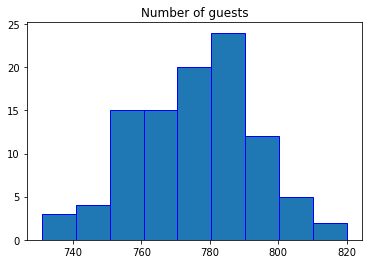

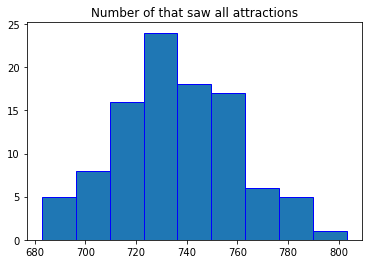

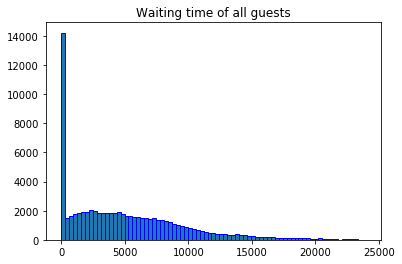

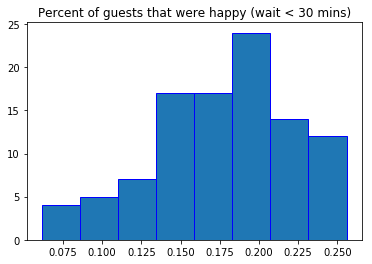

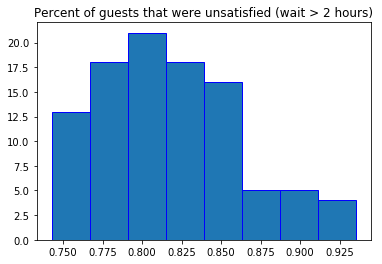

In [10]:
run_simulations(
    dock_a_slots=80,
    dock_b_slots=80,
    dock_c_slots=80,
    dock_d_slots=80,
    dock_a_bikes=80,
    dock_b_bikes=80,
    dock_c_bikes=80,
    dock_d_bikes=80,
    time_limit=150000,
    runs=100
)